### Importing all required libraries:



*   Python - 3.6.7
*   Numpy
*   Tensorflow
*   Keras
*   Natural Language Toolkit (NLTK)
*   Pandas
*   Matplotlib
*   glob
*   Python Imaging Library (PIL)



In [54]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import string
import glob
from PIL import Image
images_dir = r'C:\Users\shri\Downloads\Flickr8k_Dataset\Flicker8k_Dataset'
images = os.listdir(images_dir)

In [26]:
import pickle

In [3]:
import numpy as np
from numpy import array
import pandas as pd
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.applications.resnet50 import decode_predictions, ResNet50
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


### Exploring Dataset and getting a basic idea:

In [17]:
# loading data into memory
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

filename = r'C:\Users\shri\Downloads\Flickr8k_text\Flickr8k.token.txt'

# display descriptions
doc = load_doc(filename)
print("\t\t\tDescription text example \n\n\n")
print(doc[:410])

			Description text example 



1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


### Loading Descriptions and checking for some data:

In [18]:
def load_descriptions(doc):
	mapping = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		if len(line) < 2:
			continue
		image_id, image_desc = tokens[0], tokens[1:]
		image_id = image_id.split('.')[0]
		image_desc = ' '.join(image_desc)
		if image_id not in mapping:
			mapping[image_id] = list()
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Number of loaded descriptions: %d ' % len(descriptions))

Loaded: 8092 


Let us check the descriptions of five random images in the training 

In [33]:
sample = list(descriptions.keys())[-5:]

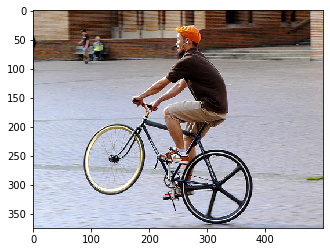

['A man does a wheelie on his bicycle on the sidewalk .', 'A man is doing a wheelie on a mountain bike .', 'A man on a bicycle is on only the back wheel .', 'Asian man in orange hat is popping a wheelie on his bike .', 'Man on a bicycle riding on only one wheel .']





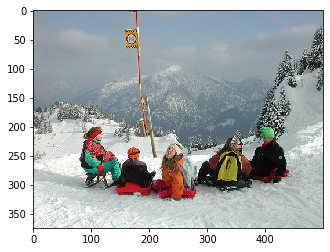

['A group is sitting around a snowy crevasse .', 'A group of people sit atop a snowy mountain .', 'A group of people sit in the snow overlooking a mountain scene .', 'Five children getting ready to sled .', 'Five people are sitting together in the snow .']





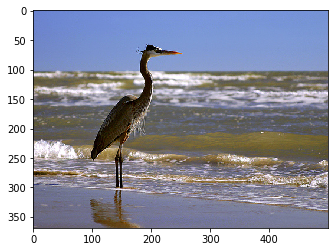

['A grey bird stands majestically on a beach while waves roll in .', 'A large bird stands in the water on the beach .', 'A tall bird is standing on the sand beside the ocean .', "A water bird standing at the ocean 's edge .", 'A white crane stands tall as it looks out upon the ocean .']





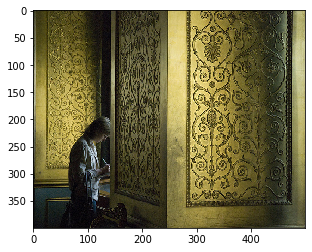

['A person stands near golden walls .', 'a woman behind a scrolled wall is writing', 'A woman standing near a decorated wall writes .', 'The walls are covered in gold and patterns .', 'Woman writing on a pad in room with gold , decorated walls .']





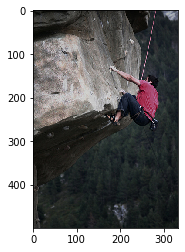

['A man in a pink shirt climbs a rock face', 'A man is rock climbing high in the air .', 'A person in a red shirt climbing up a rock face covered in assist handles .', 'A rock climber in a red shirt .', 'A rock climber practices on a rock climbing wall .']





In [39]:
for i in sample:
    string = r"C:\Users\shri\Downloads\Flickr8k_Dataset\Flicker8k_Dataset\\" + i + ".jpg"
    img = Image.open(string)
    datax=plt.imread(string)
    plt.imshow(datax)
    plt.show()
    print(descriptions[i])
    print("\n\n")
    

### Cleaning Descriptions of Images:

Converting all letters to lower case and removing unnecessary puctuations and letters

In [47]:
# function for removing punctuation
def clean_descriptions(descriptions):
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [ ]:
Let's compare the descriptions we saw previously before and after the cleaning

In [48]:
for i in sample:
    print(descriptions[i])
    print("\n\n")

['man does wheelie on his bicycle on the sidewalk', 'man is doing wheelie on mountain bike', 'man on bicycle is on only the back wheel', 'asian man in orange hat is popping wheelie on his bike', 'man on bicycle riding on only one wheel']



['group is sitting around snowy crevasse', 'group of people sit atop snowy mountain', 'group of people sit in the snow overlooking mountain scene', 'five children getting ready to sled', 'five people are sitting together in the snow']



['grey bird stands majestically on beach while waves roll in', 'large bird stands in the water on the beach', 'tall bird is standing on the sand beside the ocean', 'water bird standing at the ocean edge', 'white crane stands tall as it looks out upon the ocean']



['person stands near golden walls', 'woman behind scrolled wall is writing', 'woman standing near decorated wall writes', 'the walls are covered in gold and patterns', 'woman writing on pad in room with gold decorated walls']



['man in pink shirt climbs

### Converting Loaded descriptions into a vocabulary of words:

Building a list of all description strings

In [50]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Total Vocabulary Size: %d' % len(vocabulary))

Total Vocabulary Size: 8763


Saving all descriptions in a text file (one  per line)

In [13]:

def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

### Load a pre-defined list of photo-identifiers:

In [52]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = r'C:\Users\shri\Downloads\Flickr8k_text\Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


### Extracting all images from the dataset:

Create a list of all names in the directory

In [55]:
# Below path contains all the images
images = r'C:\Users\shri\Downloads\Flickr8k_Dataset\Flicker8k_Dataset'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

### Splitting Data into train, test and validation sets:


*   train set - 6000 images
*   validation set - 1000 images
*   test set - 1000 images



In [58]:
#Training data
train_images_file = r'C:\Users\shri\Downloads\Flickr8k_text\Flickr_8k.trainImages.txt'

train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

# Check if the image belongs to training set
for i in img: 
    if i[len(images):] in train_images: 
        train_img.append(i) 

In [59]:
# Testing data
test_images_file = r'C:\Users\shri\Downloads\Flickr8k_text\Flickr_8k.testImages.txt'

test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

test_img = []

# Check if the image belongs to test set
for i in img: 
    if i[len(images):] in test_images: 
        test_img.append(i) 

Extracting validation images and storing them in a list

In [60]:
# validation data
dev_images_file = r'C:\Users\shri\Downloads\Flickr8k_text\Flickr_8k.devImages.txt'

dev_images = set(open(dev_images_file, 'r').read().strip().split('\n'))

dev_img = []

# Check if the image belongs to test set
for i in img: 
    if i[len(images):] in dev_images: 
        dev_img.append(i) 

In [63]:
# load clean descriptions

def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions(r'C:\Users\shri\Downloads\1\descriptions.txt', train)
print('Number of descriptions loaded in train=%d' % len(train_descriptions))

Number of descriptions loaded in train=6000


In [20]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))

    x = image.img_to_array(img)

    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

#### Loading the inception v3 model:

*   Pre-trained model on many images.
*   Optionally loads weights pre-trained on ImageNet.



In [21]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 8s 0us/step


### Creating Model:

Create a new model, by removing last layer from Inception v3 as it contains all the features of the image that we need.

In [22]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

Encoding all images into a vector of size (2048, )

In [23]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [24]:
# Call the funtion to encode all the train images

start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 3580.2306365966797


In [25]:
with open(r"C:\Users\shri\Downloads\1\encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [26]:
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 614.863508939743


In [27]:

with open(r"C:\Users\shri\Downloads\1\encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [28]:
start = time()
encoding_dev = {}
for img in dev_img:
    encoding_dev[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 599.7518529891968


In [29]:
with open(r"C:\Users\shri\Downloads\1\encoded_dev_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_dev, encoded_pickle)

In [30]:
train_features = load(open(r"C:\Users\shri\Downloads\1\encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


Caption training

In [31]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

Considering only those words which occur at least 10 times in the corpus

In [32]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


Coverting all words to indexes and indexes to word

In [33]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [34]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

Convert a dictionary to a list of descriptions

In [35]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


### Defining data generator function

In [36]:

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    '''
    Generate online training data, one image at a time.
    
    Note: one image produces several "datapoints", since every token of each
    caption is a different output target.
    '''
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

### Loading Glove Vectors (200 D):

In [37]:
# Load Glove vectors
glove_dir = r'C:\Users\shri\Downloads\1\glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, r"C:\Users\shri\Downloads\1\glove\glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [38]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [39]:
embedding_matrix.shape

(1652, 200)

### Defining our LSTM model by setting different Hyper-parameters

In [88]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.2)(inputs1)
fe2 = Dense(512, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(512)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(512, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Model Summary:

In [89]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 34, 200)      330400      input_9[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 2048)         0           input_8[0][0]                    
____________________________________________________________________________________________

In [90]:
model.layers[2]

In [91]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

Using Adam optimizer and categorical crossentropy as loss function:

In [92]:
lr = 0.0005
adam = Adam(lr)
model.compile(loss='categorical_crossentropy', optimizer='adam')

Setting-up no. of epochs, batch size and steps per epoch:

In [93]:
epochs = 12
number_pics_per_bath = 30
steps = len(train_descriptions)//number_pics_per_bath

Loading validation set features and descriptions:

In [94]:
dev_features = load(open(r"C:\Users\shri\Downloads\1\encoded_dev_images.pkl", "rb"))
filename_dev = r'C:\Users\shri\Downloads\1\Flickr_8k.devImages.txt'
dev = load_set(filename_dev)
dev_descriptions = load_clean_descriptions(r'C:\Users\shrik\Downloads\1\descriptions.txt', dev)
validation_generator = data_generator(dev_descriptions, dev_features, wordtoix, max_length, number_pics_per_bath)

### Training model on specified no.of epochs on train set and validation set:

In [95]:
generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
history = model.fit_generator(generator, epochs=epochs, steps_per_epoch=steps, verbose=1, validation_data = validation_generator, validation_steps=steps)
model.save(r'C:\Users\shri\Downloads\1\model_weights/model_' + str(i) + '.h5')

Epoch 1/12
200/200 [==============================] - 119s 597ms/step - loss: 4.5525 - val_loss: 3.7577
Epoch 2/12
200/200 [==============================] - 117s 586ms/step - loss: 3.6039 - val_loss: 3.4448
Epoch 3/12
200/200 [==============================] - 117s 584ms/step - loss: 3.2860 - val_loss: 3.3188
Epoch 4/12
200/200 [==============================] - 117s 585ms/step - loss: 3.1001 - val_loss: 3.2599
Epoch 5/12
200/200 [==============================] - 117s 585ms/step - loss: 2.9618 - val_loss: 3.2244
Epoch 6/12
200/200 [==============================] - 117s 583ms/step - loss: 2.8457 - val_loss: 3.2213
Epoch 7/12
200/200 [==============================] - 117s 587ms/step - loss: 2.7473 - val_loss: 3.2241
Epoch 8/12
200/200 [==============================] - 117s 587ms/step - loss: 2.6617 - val_loss: 3.2645
Epoch 9/12
200/200 [==============================] - 117s 583ms/step - loss: 2.5846 - val_loss: 3.2566
Epoch 10/12
200/200 [==============================] - 117s 585m

### Loss plot of the model:

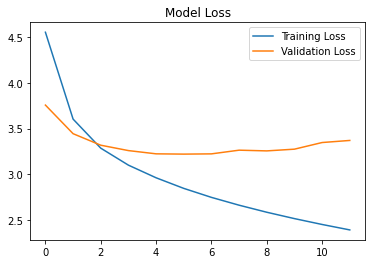

In [96]:
loss= history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.show()

In [97]:
model.save_weights(r'C:\Users\shri\Downloads\1\model_30.h5')

### Testing our model with test data:

Loading all images

In [98]:
images = r'C:\Users\shri\Downloads\Flicker8k_Dataset/'

Encoding all images into required vectors

In [99]:
with open(r"C:\Users\shri\Downloads\1\encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

### Defining Greedy Search and Beam Search for generating captions:

In [100]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [101]:
def beam_search_pred(photo, K_beams = 10, log = False):
    start_token = 'startseq'
    end_token = 'endseq'
    start = [wordtoix[start_token]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            sequence  = pad_sequences([s[0]], maxlen=max_length).reshape((1,max_length)) #sequence of most probable words
                                                                                          # based on the previous steps
            preds = model.predict([photo,sequence], verbose=0)
            word_preds = np.argsort(preds[0])[-K_beams:] # sort predictions based on the probability, then take the last
                                                          # K_beams items. words with the most probs
            # Getting the top <K_beams>(n) predictions and creating a
            # new list so as to put them via the model again
            for w in word_preds:
                
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words4
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

        # Getting the top words
        start_word = start_word[-K_beams:]
    
    start_word = start_word[-1][0]
    captions_ = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in captions_:
        if i != end_token:
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

### Testing our model by using Greedy and Beam Search:

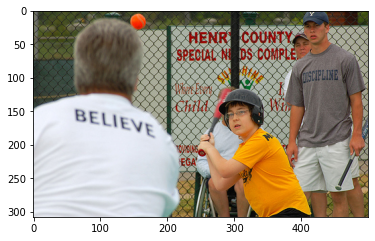

Greedy: boy in white shirt and white shorts is standing on the field
BLEU Score: 0.3073038432998781


In [115]:
import random
from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

z=random.randint(0, 999)

pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

smoothie = SmoothingFunction().method7
output = []
references = descriptions[pic.replace('.jpg','')]
references = [c.split() for c in references]
output.append(greedySearch(image))
output = [i for item in output for i in item.split()]
score = bleu(references, output, smoothing_function=smoothie)
print("BLEU Score:", score)

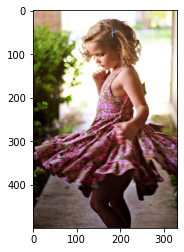

Beam: little girl in pink dress is walking down the street
BLEU Score: 0.5153543965927526


In [116]:
z=random.randint(0, 999)

pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
beam = beam_search_pred(image)
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Beam:",beam)

smoothie = SmoothingFunction().method7
output = []
references = descriptions[pic.replace('.jpg','')]
references = [c.split() for c in references]
output.append(beam)
output = [i for item in output for i in item.split()]
score = bleu(references, output, smoothing_function=smoothie)
print("BLEU Score:", score)

### Calculating average BLEU-4 scores:

In [107]:
# BLEU Score
from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

smoothie = SmoothingFunction().method7
references = []
output = []
result = []
for i in range (0, len(list(encoding_test.keys()))):
  s = list(encoding_test.keys())[i]
  
  references = descriptions[s.replace('.jpg','')]
  references = [c.split() for c in references]

  greedy = greedySearch(image)
  output.append(greedy)
  output = [i for item in output for i in item.split()]

  score = bleu(references, output, smoothing_function=smoothie)
  result.append(score)

print(result)
print("Average BLEU Score:", sum(result)/len(result))

[0.24378433052499146, 0.31172351910083307, 0.318058654875697, 0.3294380222814673, 0.327023469499603, 0.3303393419519124, 0.26901191435806093, 0.33559210231643416, 0.34067776576593045, 0.34229673841951264, 0.24700626024601688, 0.25444871745251463, 0.24921430573083256, 0.24912240143585296, 0.35040613087356737, 0.24544352757931906, 0.35058264949942836, 0.24747313190696166, 0, 0.357139367849935, 0, 0.24663726541335174, 0.24809252569371623, 0.35480206827735994, 0.3554719258834814, 0.35715410199556197, 0.3587306003707189, 0.24871139200377188, 0.35693809609410476, 0.2499283407699768, 0.35806164336343893, 0.25009837292320747, 0.3599272957984123, 0, 0.3616259046307465, 0.2504349998254548, 0.3624471330142294, 0.36140525362014275, 0.2515325880190917, 0.2500209418202372, 0.16103182596662174, 0.3636522167063732, 0, 0.25039931595950843, 0.25320309901921223, 0.25186906397919545, 0.36708274917751244, 0.2519898360211916, 0.36596162792248205, 0.25218019612574105, 0.3670874380640001, 0.3678871757194243, 

As shown in the previous cell, the average BLEU score for CNN + LSTM model is 0.32

Now for Resnet + GRU model

In [65]:
def preprocess_resnet(image_path):
    # Convert all the images to size 299x299 as expected by the Resnet model
    img = image.load_img(image_path, target_size=(299, 299))

    x = image.img_to_array(img)

    x = np.expand_dims(x, axis=0)

    x = keras.applications.resnet50.preprocess_input(x)
    return x

Loading the Resnet50 model:

    Pre-trained model on many images.
    Optionally loads weights pre-trained on ImageNet.



In [71]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [72]:
model2 = ResNet50(weights='imagenet')

102981632/102967424 [==============================] - 57s 1us/step


In [73]:
# Removing the last layer (output layer) from Resnet50
model_new2 = Model(model2.input, model2.layers[-2].output)

In [74]:
# Function to encode a given image into a vector of size (2048, )with model2
def encode2(image):
    image = preprocess(image) # preprocess the image
    fea_vec2 = model_new2.predict(image) # Get the encoding vector for the image
    fea_vec2 = np.reshape(fea_vec2, fea_vec2.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec2

In [75]:
# Call the funtion to encode all the train images
encoding_train2 = {}
for img in train_img:
    encoding_train2[img[len(images):]] = encode2(img)
    
# Call the funtion to encode all the test images
encoding_test2 = {}
for img in test_img:
    encoding_test2[img[len(images):]] = encode2(img)

# Call the funtion to encode all the validation images
encoding_dev2 = {}
for img in dev_img:
    encoding_dev2[img[len(images):]] = encode2(img)

In [79]:
train_features2 = load(open(r"C:\Users\shri\Downloads\1\encoded_train_images.pkl", "rb"))

In [81]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    '''
    Generate online training data, one image at a time.
    Note: one image produces several "datapoints", since every token of each
    caption is a different output target.
    '''
    filenames_gen = input_filenames
    print('files total:',len(filenames_gen))
    while True:
        for f in filenames_gen:
            X_img, X_txt, y = list(), list(), list()#new list for every image
            ix = np.where(filenames==f)[0][0]#find the index of the image
            img = images[ix,:]#load the image features using the index
            img_captions = captions[f[0]]#load the captions of the image
            for c in img_captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([c])[0]
                # split one sequence into multiple X,y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)#[0]
                    # store
                    X_img.append(img)#append the image features
                    X_txt.append(in_seq)
                    y.append(out_seq)
            yield([[np.array(X_img), np.array(X_txt)], np.array(y)]) 

In [82]:
#GRU MODEL

nembedding = 128
ndense = 128
nlstm = 128
dropout_rate=0.0

# feature extractor model
input_img = Input(shape=(2048,))
x_img = Dropout(dropout_rate)(input_img)
x_img = Dense(ndense, activation='relu')(x_img)

# sequence model
input_txt = Input(shape=(max_caption_length,))
x_txt = Embedding(vocab_size, nembedding, mask_zero=True)(input_txt)
x_txt = Dropout(dropout_rate)(x_txt)
x_txt = GRU(nlstm)(x_txt)

# decoder model
x_merge = concatenate([x_img, x_txt])
x_merge = Dropout(dropout_rate)(x_merge)
x_merge = Dense(ndense, activation='relu')(x_merge)

output = Dense(vocab_size, activation='softmax')(x_merge)

model2 = Model(inputs=[input_img, input_txt], outputs=output)
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [89]:
#generator for training data
filenames_tr = pd.read_csv(r'C:\Users\shri\Downloads\Flickr8k_text\Flickr_8k.trainImages.txt',header=None)
filenames_tr = np.array(filenames_tr.values.tolist())#convert to array with dtype='<U25'
gen_train = data_generator(input_filenames=filenames_tr)
steps_per_epoch_tr =  len(filenames_tr)

In [91]:
#generator for validation data
filenames_val = pd.read_csv(r'C:\Users\shri\Downloads\Flickr8k_text\Flickr_8k.devImages.txt',header=None)
filenames_val = np.array(filenames_val.values.tolist())#convert to array with dtype='<U25'
gen_val = data_generator(input_filenames=filenames_val)
steps_per_epoch_val = len(filenames_val)

In [92]:
#Saving data

filepath=r'C:\Users\shri\Downloads\Flickr8k_text\model128_GRU_dropout'+str(dropout_rate) #to save the weights
#save model architecture as a .png file
plot_model(model, to_file=filepath+'.png', show_shapes=True)
#save tokenizer to use on new datasets
with open(r'C:\Users\shri\Downloads\1\_tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [93]:
checkpoint = ModelCheckpoint(filepath+'.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlog = CSVLogger(filepath+'_train_log.csv',append=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [94]:
model.fit_generator(generator=gen_train,steps_per_epoch=steps_per_epoch_tr,
                    validation_data=gen_val,validation_steps=steps_per_epoch_val,
                 epochs=10, verbose=0,
                 initial_epoch=0,callbacks=[checkpoint, csvlog, early_stopping])

In [95]:
# generate a single caption for an image
def generate_caption(img, model, tokenizer, max_caption_length):
    '''
    img: the input image used to generate the captions
    tokenizer: a (fitted) tokenizer
    max_caption_length: the maximum number of words/tokens to produce
    '''
    # seed the generation process
    in_text = '<START>'
    img = img.reshape((1,)+img.shape)
    # iterate over the whole length of the sequence
    for i in range(max_caption_length):
        # encode each text sequence to an integer sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input to max_caption_length size
        sequence = pad_sequences([sequence], maxlen=max_caption_length)
        #sequence = sequence.reshape((1,)+sequence.shape)
        # predict next word/token
        next_id = model.predict([img,sequence], verbose=0)
        # select the class (integer index) with the highest probability
        next_id = np.argmax(next_id)
        # map integer index to word
        word = index_to_token(next_id, tokenizer)
        #print('next word',word)
        # stop if we cannot map the word
        if word is None:
            #print('found None, exiting')
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == '<END>':
            break
    return in_text

In [98]:
description2 = {}
for img in images:
    description2[img] = generate_caption(img, model2, tokenizer, 400)

In [100]:
smoothie = SmoothingFunction().method7
references = []
output = []
result = []
for i in range (0, len(list(encoding_test.keys()))):
  s = list(encoding_test.keys())[i]
  
  references = descriptions2[s.replace('.jpg','')]
  references = [c.split() for c in references]

  greedy = greedySearch(image)
  output.append(greedy)
  output = [i for item in output for i in item.split()]

  score = bleu(references, output, smoothing_function=smoothie)
  result.append(score)

print("Average BLEU Score:", sum(result)/len(result))

Average BLEU score: 0.273668


Some other findings using different hyperparameters (not the final model):

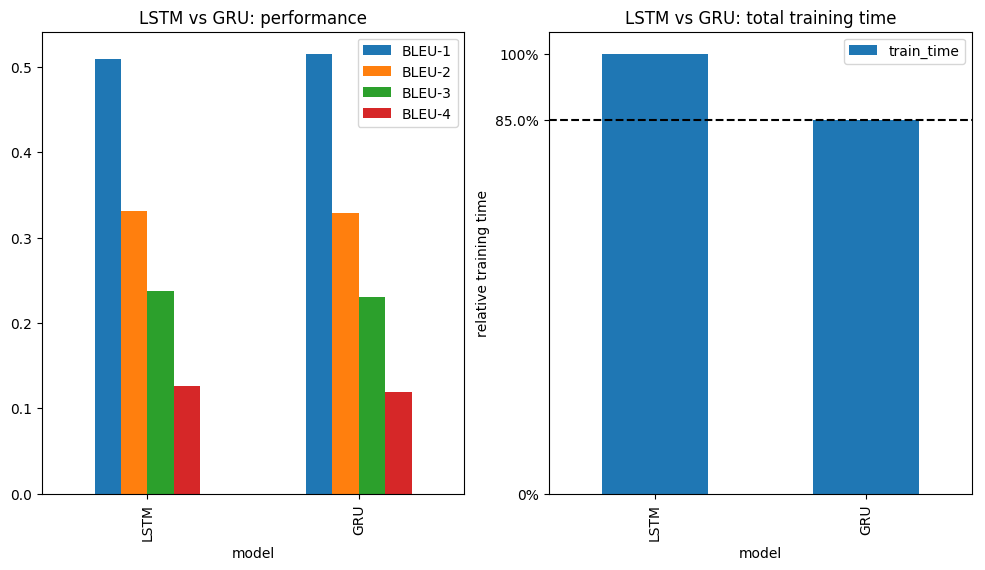

In [103]:
from IPython.display import Image
Image(filename=r"C:\Users\shri\compare_model.png") 

FINDINGS:


We have compared the models and have found that the LSTM version offers a higher BLEU score, implying a higher real world efficiency of caption relevance.

Some more examples:

GRU:

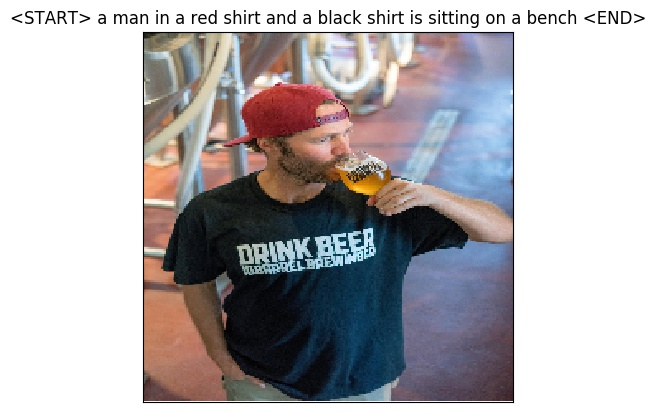

In [107]:
Image(filename=r"C:\Users\shri\GRU1.jpeg") 

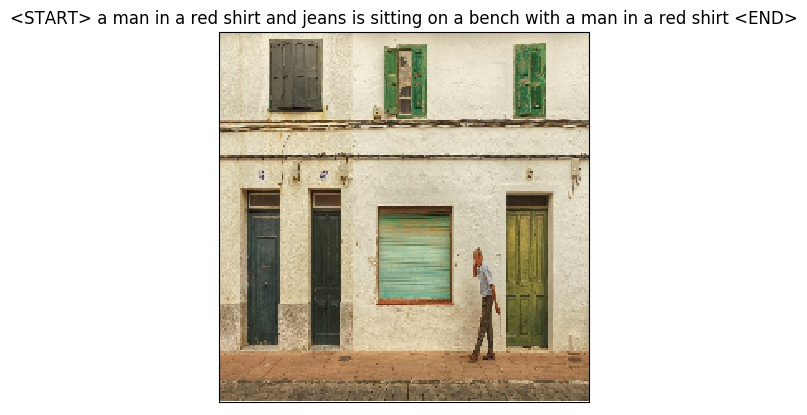

In [108]:
Image(filename=r"C:\Users\shri\GRU2.jpeg") 

LSTM:

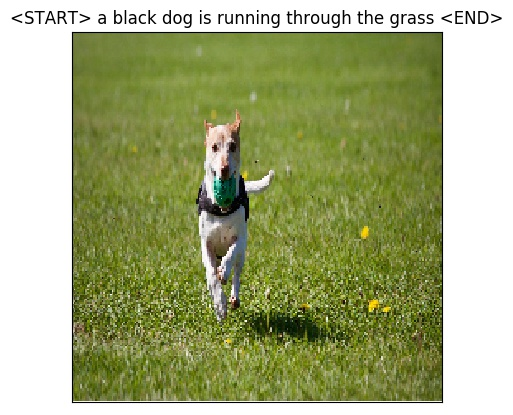

In [110]:
Image(filename=r"C:\Users\shri\LSTM1.jpeg") 

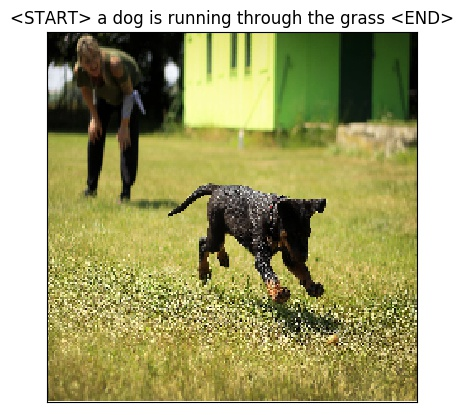

In [111]:
Image(filename=r"C:\Users\shri\LSTM2.jpeg") 